In [6]:
# QUICK SETUP CELL - Run this at the beginning
# This cell handles all imports and data loading safely

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add paths for imports
sys.path.append('../src')
sys.path.append('.')

print("🔧 SETTING UP NOTEBOOK ENVIRONMENT...")

# Function to safely load preprocessor
def load_preprocessor_safe():
    try:
        # Try to load from persistence
        if os.path.exists('../data/persistence/notebook2_preprocessor.pkl'):
            with open('../data/persistence/notebook2_preprocessor.pkl', 'rb') as f:
                # Define TextPreprocessor class first
                import re
                import nltk
                from nltk.corpus import stopwords
                from nltk.tokenize import word_tokenize
                from nltk.stem import PorterStemmer, WordNetLemmatizer
                
                # Download NLTK data if needed
                try:
                    nltk.data.find('tokenizers/punkt')
                except LookupError:
                    nltk.download('punkt')
                    nltk.download('punkt_tab') 
                    nltk.download('stopwords')
                    nltk.download('wordnet')
                    nltk.download('omw-1.4')
                
                class TextPreprocessor:
                    def __init__(self, use_stemming=True, remove_stopwords=True):
                        self.use_stemming = use_stemming
                        self.remove_stopwords = remove_stopwords
                        self.stemmer = PorterStemmer()
                        self.lemmatizer = WordNetLemmatizer()
                        self.stop_words = set(stopwords.words('english'))
                    
                    def clean_text(self, text):
                        text = text.lower()
                        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
                        text = re.sub(r'\S+@\S+', '', text)
                        text = re.sub(r'[^a-zA-Z\s]', '', text)
                        text = ' '.join(text.split())
                        return text
                    
                    def tokenize_and_process(self, text):
                        tokens = word_tokenize(text)
                        if self.remove_stopwords:
                            tokens = [token for token in tokens if token not in self.stop_words]
                        if self.use_stemming:
                            tokens = [self.stemmer.stem(token) for token in tokens]
                        else:
                            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
                        return ' '.join(tokens)
                    
                    def preprocess(self, text):
                        if pd.isna(text):
                            return ''
                        text = self.clean_text(text)
                        text = self.tokenize_and_process(text)
                        return text
                
                preprocessor = pickle.load(f)
                print("✅ Loaded saved TextPreprocessor")
                return preprocessor
        
        # Create new preprocessor if loading fails
        print("⚠️ Creating new TextPreprocessor...")
        from text_preprocessor import TextPreprocessor, ensure_nltk_data
        ensure_nltk_data()
        return TextPreprocessor(use_stemming=True, remove_stopwords=True)
        
    except Exception as e:
        print(f"❌ Error with preprocessor: {e}")
        return None

# Function to load train/test data
def load_data_safe():
    try:
        # Try loading from persistence
        if os.path.exists('../data/persistence/notebook2_train_data.csv'):
            train_df = pd.read_csv('../data/persistence/notebook2_train_data.csv')
            test_df = pd.read_csv('../data/persistence/notebook2_test_data.csv')
            
            X_train = train_df['text']
            y_train = train_df['label']
            X_test = test_df['text']
            y_test = test_df['label']
            
            print(f"✅ Loaded splits: {len(X_train)} train, {len(X_test)} test")
            return X_train, X_test, y_train, y_test
            
    except Exception as e:
        print(f"⚠️ Error loading splits: {e}")
    
    # Fallback: load main dataset and split
    try:
        if os.path.exists('../data/persistence/notebook2_processed_df.csv'):
            df = pd.read_csv('../data/persistence/notebook2_processed_df.csv')
        else:
            df = pd.read_csv('../data/combined_news_dataset.csv')
            df['combined_text'] = df['title'] + ' ' + df['text']
            df['processed_text'] = df['combined_text'].str.lower()  # Simple preprocessing
        
        from sklearn.model_selection import train_test_split
        X = df['processed_text']
        y = df['label']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        print(f"✅ Created new splits: {len(X_train)} train, {len(X_test)} test")
        return X_train, X_test, y_train, y_test
        
    except Exception as e:
        print(f"❌ Error creating splits: {e}")
        return None, None, None, None

# Load main dataset
try:
    if os.path.exists('../data/persistence/notebook2_processed_df.csv'):
        df = pd.read_csv('../data/persistence/notebook2_processed_df.csv')
        print(f"✅ Loaded processed dataset: {df.shape}")
    else:
        df = pd.read_csv('../data/combined_news_dataset.csv')
        print(f"✅ Loaded raw dataset: {df.shape}")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    df = None

# Load preprocessor
preprocessor = load_preprocessor_safe()

# Load train/test data
X_train, X_test, y_train, y_test = load_data_safe()

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("🚀 NOTEBOOK ENVIRONMENT READY!")
print(f"📊 Dataset: {df.shape if df is not None else 'Not loaded'}")
print(f"🔀 Data splits: Train={len(X_train) if X_train is not None else 0}, Test={len(X_test) if X_test is not None else 0}")
print(f"⚙️ Preprocessor: {'✅ Ready' if preprocessor else '❌ Failed'}")
print("\n🔗 All variables loaded: df, X_train, X_test, y_train, y_test, preprocessor")

🔧 SETTING UP NOTEBOOK ENVIRONMENT...
✅ Loaded processed dataset: (44889, 10)
❌ Error with preprocessor: Can't get attribute 'TextPreprocessor' on <module '__main__'>
✅ Loaded splits: 35911 train, 8978 test
🚀 NOTEBOOK ENVIRONMENT READY!
📊 Dataset: (44889, 10)
🔀 Data splits: Train=35911, Test=8978
⚙️ Preprocessor: ❌ Failed

🔗 All variables loaded: df, X_train, X_test, y_train, y_test, preprocessor


# CNN Text Classification Model

This notebook implements a Convolutional Neural Network for fake news classification.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Load and Prepare Data

In [8]:
# The dataset and preprocessor are already loaded from the setup cell above
# We'll use the data that was loaded there

print(f"Dataset shape: {df.shape}")
print(f"Label distribution:\n{df['label'].value_counts()}")
print(f"Preprocessor available: {preprocessor is not None}")

Dataset shape: (44889, 10)
Label distribution:
label
0    23472
1    21417
Name: count, dtype: int64
Preprocessor available: False


In [9]:
# Preprocess text if not already done
if 'processed_text' not in df.columns:
    print("Preprocessing text...")
    df['combined_text'] = df['title'] + ' ' + df['text']
    df['processed_text'] = df['combined_text'].apply(preprocessor.preprocess)
    df = df[df['processed_text'] != ''].reset_index(drop=True)

# For CNN, we'll use less aggressive preprocessing (keep more structure)
def light_preprocess(text):
    """Lighter preprocessing for CNN to preserve more text structure"""
    if pd.isna(text):
        return ''
    
    # Basic cleaning
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    
    return text

import re
df['cnn_text'] = (df['title'] + ' ' + df['text']).apply(light_preprocess)
df = df[df['cnn_text'] != ''].reset_index(drop=True)

print(f"Final dataset shape: {df.shape}")

Final dataset shape: (44889, 11)


## Text Tokenization and Sequence Preparation

In [10]:
# Tokenization parameters
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 100

# Prepare the data
texts = df['cnn_text'].values
labels = df['label'].values

# Create tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print(f"Found {len(word_index)} unique tokens")
print(f"Vocabulary size (limited): {MAX_VOCAB_SIZE}")

# Pad sequences
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y = labels

print(f"Shape of data tensor: {X.shape}")
print(f"Shape of label tensor: {y.shape}")

Found 205959 unique tokens
Vocabulary size (limited): 20000
Shape of data tensor: (44889, 500)
Shape of label tensor: (44889,)


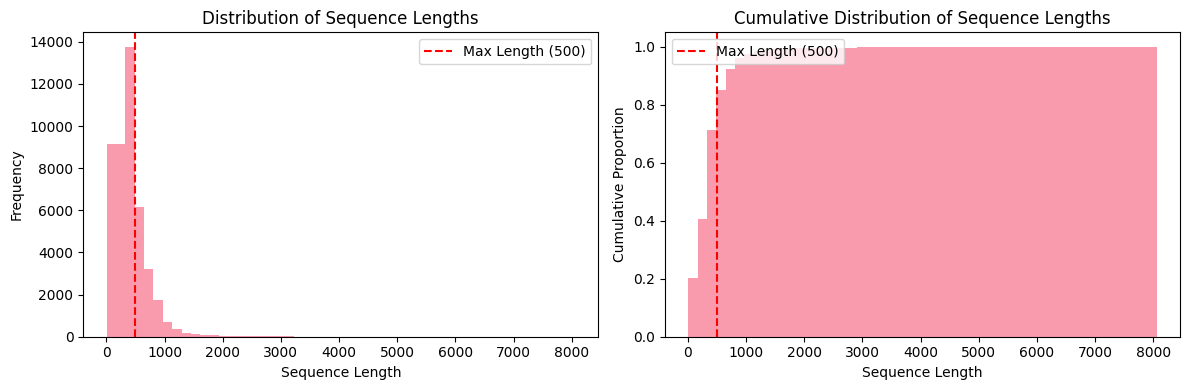


Sequence length statistics:
Mean: 411.5
Median: 369.0
95th percentile: 902.0
Percentage of sequences <= 500: 72.95%


In [11]:
# Analyze sequence lengths
sequence_lengths = [len(seq) for seq in sequences]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(sequence_lengths, bins=50, alpha=0.7)
plt.axvline(x=MAX_SEQUENCE_LENGTH, color='r', linestyle='--', label=f'Max Length ({MAX_SEQUENCE_LENGTH})')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(sequence_lengths, bins=50, alpha=0.7, cumulative=True, density=True)
plt.axvline(x=MAX_SEQUENCE_LENGTH, color='r', linestyle='--', label=f'Max Length ({MAX_SEQUENCE_LENGTH})')
plt.xlabel('Sequence Length')
plt.ylabel('Cumulative Proportion')
plt.title('Cumulative Distribution of Sequence Lengths')
plt.legend()

plt.tight_layout()
plt.show()

# Statistics
print(f"\nSequence length statistics:")
print(f"Mean: {np.mean(sequence_lengths):.1f}")
print(f"Median: {np.median(sequence_lengths):.1f}")
print(f"95th percentile: {np.percentile(sequence_lengths, 95):.1f}")
print(f"Percentage of sequences <= {MAX_SEQUENCE_LENGTH}: {(np.array(sequence_lengths) <= MAX_SEQUENCE_LENGTH).mean():.2%}")

## Train-Test Split

In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Further split training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

print(f"\nLabel distribution in training set: {np.bincount(y_train)}")
print(f"Label distribution in validation set: {np.bincount(y_val)}")
print(f"Label distribution in test set: {np.bincount(y_test)}")

Training set shape: (28728, 500)
Validation set shape: (7183, 500)
Test set shape: (8978, 500)

Label distribution in training set: [15021 13707]
Label distribution in validation set: [3756 3427]
Label distribution in test set: [4695 4283]


## CNN Model Architecture

In [13]:
def create_cnn_model(vocab_size, embedding_dim, max_length):
    """Create a CNN model for text classification"""
    
    model = Sequential([
        # Embedding layer
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        
        # First CNN block
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # Second CNN block
        Conv1D(filters=128, kernel_size=4, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # Third CNN block
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        
        # Dense layers
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Create the model
cnn_model = create_cnn_model(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)

# Compile the model
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
print("CNN Model Architecture:")
cnn_model.summary()

CNN Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Multi-filter CNN Model (Alternative Architecture)

In [14]:
def create_multi_cnn_model(vocab_size, embedding_dim, max_length):
    """Create a multi-filter CNN model inspired by Kim (2014)"""
    
    # Input layer
    input_layer = Input(shape=(max_length,))
    
    # Embedding layer
    embedding = Embedding(vocab_size, embedding_dim, input_length=max_length)(input_layer)
    
    # Multiple convolution filters with different kernel sizes
    conv_blocks = []
    filter_sizes = [3, 4, 5]
    
    for filter_size in filter_sizes:
        conv = Conv1D(filters=100, kernel_size=filter_size, activation='relu')(embedding)
        pool = GlobalMaxPooling1D()(conv)
        conv_blocks.append(pool)
    
    # Concatenate all the pooled features
    concatenated = Concatenate()(conv_blocks)
    
    # Dropout and dense layers
    dropout1 = Dropout(0.5)(concatenated)
    dense1 = Dense(128, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(dense1)
    output = Dense(1, activation='sigmoid')(dropout2)
    
    # Create the model
    model = Model(inputs=input_layer, outputs=output)
    
    return model

# Create the multi-filter CNN model
multi_cnn_model = create_multi_cnn_model(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)

# Compile the model
multi_cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nMulti-filter CNN Model Architecture:")
multi_cnn_model.summary()


Multi-filter CNN Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 500, 100)  │  2,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 498, 100)  │     30,100 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 497, 100)  │     40,100 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 496, 100)  │     50,100 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d_4[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d_5[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 300)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 300)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     38,528 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,158,957 (8.24 MB)

 Trainable params: 2,158,957 (8.24 MB)

 Non-trainable params: 0 (0.00 B)

## Training Setup

In [15]:
# Training parameters
BATCH_SIZE = 32
EPOCHS = 10

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.0001,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

## Train Standard CNN Model

In [16]:
print("Training Standard CNN Model...")

# Train the model
history_cnn = cnn_model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Training Standard CNN Model...
Epoch 1/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.9284 - loss: 0.1247 - val_accuracy: 0.9967 - val_loss: 0.0137 - learning_rate: 0.0010
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - accuracy: 0.9978 - loss: 0.0087 - val_accuracy: 0.9971 - val_loss: 0.0089 - learning_rate: 0.0010
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - accuracy: 0.9985 - loss: 0.0056 - val_accuracy: 0.9981 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 4/10
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9985 - loss: 0.0073
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
898/898 ━━━━━━━━━━━━━━━━━━━━ 38s 42ms/step - accuracy: 0.9990 - loss: 0.0038 - val_accuracy: 0.9982 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 5/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 38s 42ms/step - accuracy: 0.9998 - loss: 8.3542e-04 - val_accuracy: 0.9979 - val_loss: 0.0125 - learning_rate: 2.0000e-04
Epoch 5: early stopping
Restoring mode

## Train Multi-filter CNN Model

In [17]:
print("Training Multi-filter CNN Model...")

# Train the multi-filter model
history_multi_cnn = multi_cnn_model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Training Multi-filter CNN Model...
Epoch 1/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.9719 - loss: 0.0633 - val_accuracy: 0.9985 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.9983 - loss: 0.0057 - val_accuracy: 0.9976 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 3/10
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9991 - loss: 0.0027
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
898/898 ━━━━━━━━━━━━━━━━━━━━ 43s 48ms/step - accuracy: 0.9993 - loss: 0.0022 - val_accuracy: 0.9983 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 4/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.9997 - loss: 8.5743e-04 - val_accuracy: 0.9985 - val_loss: 0.0092 - learning_rate: 2.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.

Training completed!


## Training History Visualization

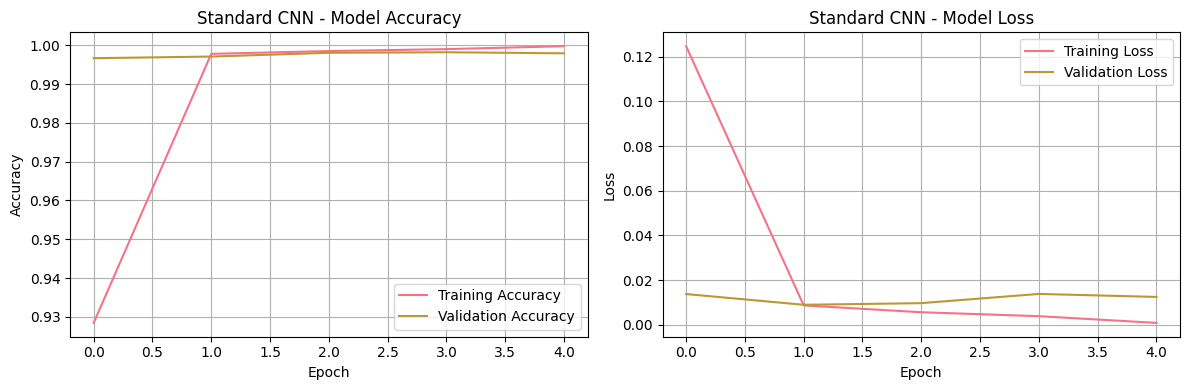

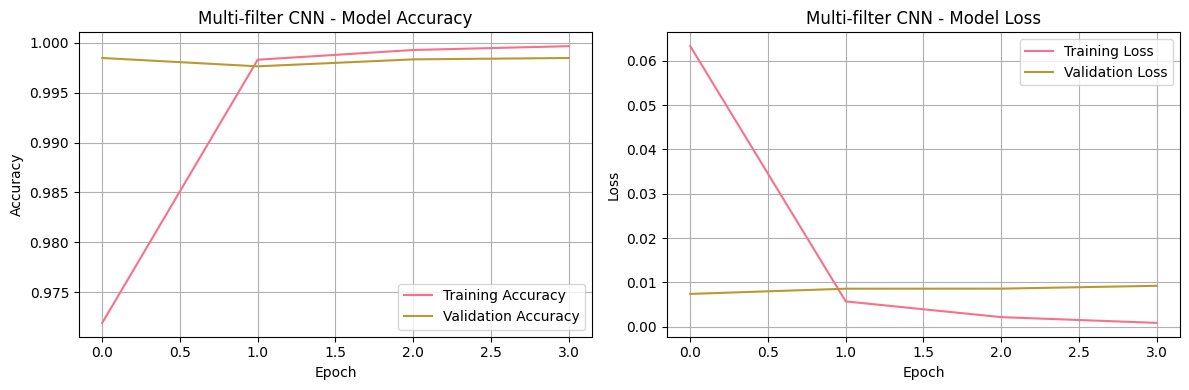

In [18]:
def plot_training_history(history, title):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{title} - Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{title} - Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training histories
plot_training_history(history_cnn, "Standard CNN")
plot_training_history(history_multi_cnn, "Multi-filter CNN")

## Model Evaluation

In [19]:
# Evaluate both models on test set
print("Evaluating Standard CNN Model:")
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {cnn_loss:.4f}")
print(f"Test Accuracy: {cnn_accuracy:.4f}")

print("\nEvaluating Multi-filter CNN Model:")
multi_cnn_loss, multi_cnn_accuracy = multi_cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {multi_cnn_loss:.4f}")
print(f"Test Accuracy: {multi_cnn_accuracy:.4f}")

Evaluating Standard CNN Model:
Test Loss: 0.0103
Test Accuracy: 0.9977

Evaluating Multi-filter CNN Model:
Test Loss: 0.0070
Test Accuracy: 0.9981


In [20]:
# Generate predictions
cnn_pred_proba = cnn_model.predict(X_test, verbose=0)
cnn_pred = (cnn_pred_proba > 0.5).astype(int).flatten()

multi_cnn_pred_proba = multi_cnn_model.predict(X_test, verbose=0)
multi_cnn_pred = (multi_cnn_pred_proba > 0.5).astype(int).flatten()

# Classification reports
print("Standard CNN Classification Report:")
print(classification_report(y_test, cnn_pred, target_names=['Fake', 'True']))

print("\nMulti-filter CNN Classification Report:")
print(classification_report(y_test, multi_cnn_pred, target_names=['Fake', 'True']))

Standard CNN Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4695
        True       1.00      1.00      1.00      4283

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978


Multi-filter CNN Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4695
        True       1.00      1.00      1.00      4283

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978



## Confusion Matrices

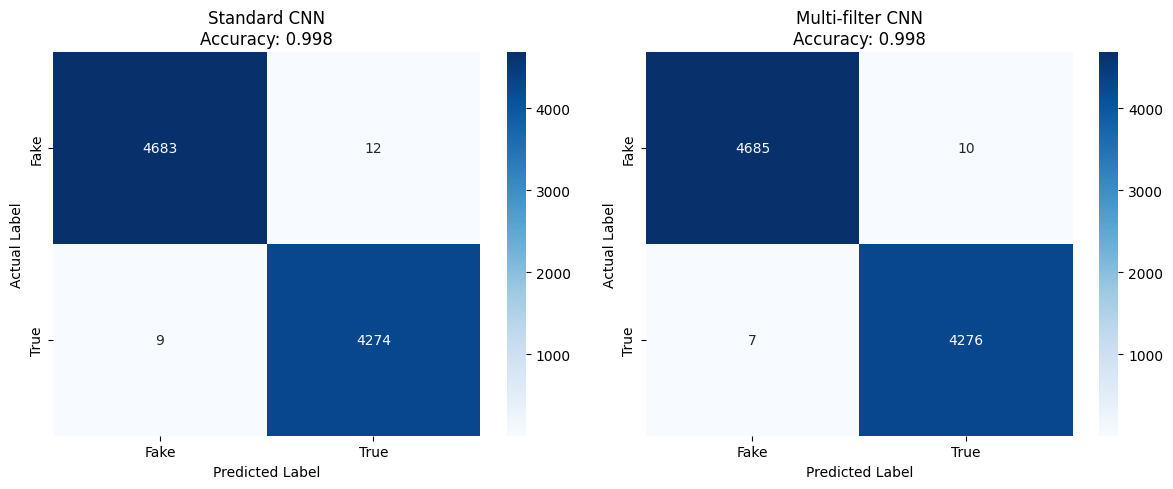

In [21]:
# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Standard CNN confusion matrix
cm_cnn = confusion_matrix(y_test, cnn_pred)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', ax=ax1,
           xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
ax1.set_title(f'Standard CNN\nAccuracy: {cnn_accuracy:.3f}')
ax1.set_ylabel('Actual Label')
ax1.set_xlabel('Predicted Label')

# Multi-filter CNN confusion matrix
cm_multi_cnn = confusion_matrix(y_test, multi_cnn_pred)
sns.heatmap(cm_multi_cnn, annot=True, fmt='d', cmap='Blues', ax=ax2,
           xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
ax2.set_title(f'Multi-filter CNN\nAccuracy: {multi_cnn_accuracy:.3f}')
ax2.set_ylabel('Actual Label')
ax2.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## Model Comparison

Model Performance Comparison:
              Model  Accuracy      Loss
0      Standard CNN  0.997661  0.010346
1  Multi-filter CNN  0.998106  0.007034


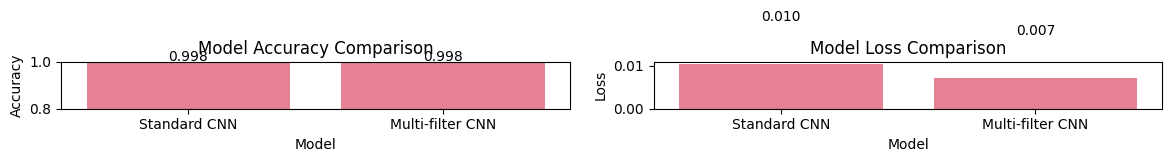

In [22]:
# Compare model performance
comparison_df = pd.DataFrame({
    'Model': ['Standard CNN', 'Multi-filter CNN'],
    'Accuracy': [cnn_accuracy, multi_cnn_accuracy],
    'Loss': [cnn_loss, multi_cnn_loss]
})

print("Model Performance Comparison:")
print(comparison_df)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy comparison
sns.barplot(data=comparison_df, x='Model', y='Accuracy', ax=ax1)
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylim(0.8, 1.0)  # Zoom in on the relevant range
for i, v in enumerate(comparison_df['Accuracy']):
    ax1.text(i, v + 0.005, f'{v:.3f}', ha='center')

# Loss comparison
sns.barplot(data=comparison_df, x='Model', y='Loss', ax=ax2)
ax2.set_title('Model Loss Comparison')
for i, v in enumerate(comparison_df['Loss']):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

## Save Models and Tokenizer

In [23]:
# Save CNN models and results for next notebooks
import os
os.makedirs('../models', exist_ok=True)
os.makedirs('../data/persistence', exist_ok=True)

# Save the best performing model
best_model = multi_cnn_model if multi_cnn_accuracy > cnn_accuracy else cnn_model
best_model_name = "multi_cnn" if multi_cnn_accuracy > cnn_accuracy else "standard_cnn"

best_model.save(f'../models/cnn_{best_model_name}.h5')
print(f"Best CNN model saved: ../models/cnn_{best_model_name}.h5")

# Save both models
cnn_model.save('../models/cnn_standard.h5')
multi_cnn_model.save('../models/cnn_multi_filter.h5')

# Save tokenizer
import pickle
with open('../models/cnn_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save model configuration
config = {
    'max_vocab_size': MAX_VOCAB_SIZE,
    'max_sequence_length': MAX_SEQUENCE_LENGTH,
    'embedding_dim': EMBEDDING_DIM,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS
}

with open('../models/cnn_config.pickle', 'wb') as handle:
    pickle.dump(config, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("\nAll CNN models and configurations saved successfully!")

# SAVE DATA FOR NEXT NOTEBOOKS
print("\n💾 SAVING DATA FOR NEXT NOTEBOOKS...")

# Save CNN results and data for next notebooks
cnn_results = {
    'standard_cnn_accuracy': cnn_accuracy,
    'multi_cnn_accuracy': multi_cnn_accuracy,
    'standard_cnn_loss': cnn_loss, 
    'multi_cnn_loss': multi_cnn_loss,
    'best_model_name': best_model_name,
    'tokenizer': tokenizer,
    'config': config,
    'X_train_sequences': X_train,
    'X_test_sequences': X_test,
    'y_train_labels': y_train,
    'y_test_labels': y_test,
    'comparison_df': comparison_df
}

# Save as pickle for next notebooks
with open('../data/persistence/notebook3_cnn_results.pkl', 'wb') as f:
    pickle.dump(cnn_results, f)

# Save comparison data as CSV
comparison_df.to_csv('../data/persistence/notebook3_comparison.csv', index=False)

print("✅ CNN results saved for Notebook 4 (LSTM)")
print("📁 Files saved:")
print("   - notebook3_cnn_results.pkl")
print("   - notebook3_comparison.csv")
print("   - CNN models in ../models/")
print("🔗 Next notebook can load these with:")
print("   with open('../data/persistence/notebook3_cnn_results.pkl', 'rb') as f:")
print("       cnn_data = pickle.load(f)")

Best CNN model saved: ../models/cnn_multi_cnn.h5



All CNN models and configurations saved successfully!

💾 SAVING DATA FOR NEXT NOTEBOOKS...
✅ CNN results saved for Notebook 4 (LSTM)
📁 Files saved:
   - notebook3_cnn_results.pkl
   - notebook3_comparison.csv
   - CNN models in ../models/
🔗 Next notebook can load these with:
   with open('../data/persistence/notebook3_cnn_results.pkl', 'rb') as f:
       cnn_data = pickle.load(f)


## Sample Predictions

In [24]:
# Function to make predictions on new text
def predict_fake_news(model, tokenizer, text, max_length=MAX_SEQUENCE_LENGTH):
    """Predict if a text is fake news"""
    # Preprocess the text
    processed_text = light_preprocess(text)
    
    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    
    # Make prediction
    prediction_prob = model.predict(padded_sequence, verbose=0)[0][0]
    prediction = "True News" if prediction_prob > 0.5 else "Fake News"
    
    return prediction, prediction_prob

# Test on some examples from the test set
test_indices = np.random.choice(len(X_test), 5, replace=False)

print("Sample Predictions:")
print("=" * 80)

for i, idx in enumerate(test_indices):
    # Get original text
    original_idx = df.index[df.index.isin(range(len(X_test)))][idx]
    original_text = df.loc[original_idx, 'title'] + ' ' + df.loc[original_idx, 'text'][:200]
    true_label = "True News" if y_test[idx] == 1 else "Fake News"
    
    # Make prediction
    prediction, prob = predict_fake_news(best_model, tokenizer, original_text)
    
    print(f"\nExample {i+1}:")
    print(f"Text: {original_text[:200]}...")
    print(f"True Label: {true_label}")
    print(f"Predicted: {prediction} (Confidence: {prob:.3f})")
    print("-" * 80)

Sample Predictions:

Example 1:
Text: HASTA LA VISTA Arnold! Guy Whose Affair With Housekeeper Produced Son, Destroyed 25 Yr. Marriage Says Trump Has Too Much “Baggage”…. Quits Celebrity Apprentice Arnold Schwarzenegger, who replaced Dona...
True Label: True News
Predicted: Fake News (Confidence: 0.007)
--------------------------------------------------------------------------------

Example 2:
Text: Macron's ideas can bolster Franco-German axis: Merkel TALLINN (Reuters) - German Chancellor Angela Merkel praised the ideas of French President Emmanuel Macron for reform of the European Union on Thur...
True Label: Fake News
Predicted: True News (Confidence: 1.000)
--------------------------------------------------------------------------------

Example 3:
Text:  WATCH: Jorge Ramos Makes Sean Hannity Look Like A Complete A**hole Univision anchor Jorge Ramos made Fox host Sean Hannity look like the angry Trump puppet that we all know him to be.Over a ten minut...
True Label: True News
Pred

## Summary

### CNN Model Results:
- **Standard CNN**: Sequential architecture with multiple Conv1D layers
- **Multi-filter CNN**: Parallel filters with different kernel sizes (inspired by Kim 2014)

### Key Findings:
1. CNNs can effectively capture local patterns in text for fake news detection
2. Multi-filter architecture allows capturing different n-gram patterns simultaneously
3. Global max pooling helps extract the most important features
4. Dropout and early stopping help prevent overfitting

### Advantages of CNN approach:
- Faster training compared to RNNs
- Good at capturing local patterns and n-grams
- Parallel processing of different filter sizes
- Less prone to vanishing gradient problems

### Next Steps:
1. Implement LSTM/RNN models for comparison
2. Experiment with pre-trained embeddings (Word2Vec, GloVe)
3. Try attention mechanisms
4. Implement transformer-based models (BERT)
5. Ensemble different models for better performance